# **Image Upsampling**

## Download Dataset from Kaggle

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [8]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 98% 773M/788M [00:06<00:00, 84.9MB/s]
100% 788M/788M [00:07<00:00, 117MB/s] 


In [9]:
!unzip -qq microsoft-catsvsdogs-dataset.zip

## Load Libraries

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

import cv2 as cv
import numpy as np
import random
import os

import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm

## Folder Management

In [11]:
for i in os.listdir('PetImages/Cat'):
  os.rename(f'PetImages/Cat/{i}', f'PetImages/Cat/cat{i}')

for i in os.listdir('PetImages/Dog'):
  os.rename(f'PetImages/Dog/{i}', f'PetImages/Dog/dog{i}')

!mv PetImages/Cat/* PetImages/
!mv PetImages/Dog/* PetImages/
!rmdir PetImages/Cat
!rmdir PetImages/Dog

In [12]:
!mkdir /content/pet320

In [13]:
# Convert all images shape (320, 320)
base_list = os.listdir('PetImages')

for i in tqdm(base_list):
  try:
    img = cv.imread('/content/PetImages/' + i)
    img = cv.resize(img, (320, 320))
    cv.imwrite(f'/content/pet320/{i}', img)
    
  except Exception as e:
    pass

  0%|          | 0/25002 [00:00<?, ?it/s]

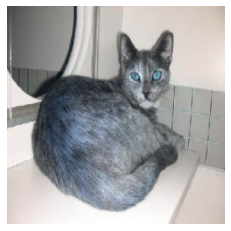

In [34]:
img = cv.imread('pet320/cat30.jpg', cv.IMREAD_ANYCOLOR)
plt.imshow(img)
plt.axis('off')
plt.show()

## Data Loader

In [67]:
class SSDataLoader:
  '''
    ## SSDataLoader

    Super sampling data loader, this loader class is written for supersampling 
    applications. 
    Loader, specialized for 320x320 images, and loads images in minibatches.

    ---------------------------------------------------------------------------
    ### Args
    
    folder     : Path of folder which contains images
    batchsize  : Batch size for each load process
    input_size : Image sizes for nn's input
    '''
  def __init__(self, folder : str, 
               batchsize : int=64, 
               input_size : tuple=(80, 80)):
    
    self.folder = folder
    self.bsize = batchsize
    self.batch_out = batchsize

    # Low res sizes
    self.limsize = input_size

    # List of images
    imglist = os.listdir(folder)
    random.shuffle(imglist)

    # Find max batch
    self.max_ = len(imglist) // self.bsize

    # Drop surplus imgs from list
    self.imglist = imglist[:(len(imglist) - self.max_)].copy()

    # Declare start and end
    self.start = 0
    self.end = self.start + self.bsize
  

  def reset(self):
    self.start = 0
    self.end = 0
    random.shuffle(self.imglist)


  def __iter__(self):
    return self


  def __next__(self):
    # Slice batch
    batch = self.imglist[self.start:(self.start+self.bsize)]
    
    if len(batch) == 0:
      raise StopIteration

    # Update start and end
    self.start += self.bsize
    self.end = self.start + self.bsize
    
    channel_R = []
    channel_G = []
    channel_B = []
    
    label_R = []
    label_G = []
    label_B = []

    for i in batch:
      # Read and resize images
      img = cv.imread(f'{self.folder}/{i}', cv.IMREAD_ANYCOLOR)
      if img is None:
        continue
      
      img = img / 255.0

      # Create input and label images
      img_input = cv.resize(img, self.limsize)
      im_R = img_input[:, :, 2]
      im_G = img_input[:, :, 1]
      im_B = img_input[:, :, 0]

      img_label = img.copy()
      out_R = img_label[:, :, 2]
      out_G = img_label[:, :, 1]
      out_B = img_label[:, :, 0]
      
      # If shape of input correct then add to the lists
      if im_R.shape == (self.limsize[0], self.limsize[1]):
        channel_R.append(im_R)
        channel_G.append(im_G)
        channel_B.append(im_B)

        label_R.append(out_R)
        label_G.append(out_G)
        label_B.append(out_B)
    
    # Convert inputs to torch Tensor
    featuresR = np.array(channel_R, dtype=np.float32)
    featuresR = np.reshape(featuresR, (-1, 1, self.limsize[0], self.limsize[1]))
    featuresR = torch.Tensor(featuresR)

    featuresG = np.array(channel_G, dtype=np.float32)
    featuresG = np.reshape(featuresG, (-1, 1, self.limsize[0], self.limsize[1]))
    featuresG = torch.Tensor(featuresG)

    featuresB = np.array(channel_B, dtype=np.float32)
    featuresB = np.reshape(featuresB, (-1, 1, self.limsize[0], self.limsize[1]))
    featuresB = torch.Tensor(featuresB)

    # Convert labels to torch Tensor
    labelR = np.array(label_R, dtype=np.float32)
    labelR = np.reshape(labelR, (-1, 1, 320, 320))
    labelR = torch.Tensor(labelR)

    labelG = np.array(label_G, dtype=np.float32)
    labelG = np.reshape(labelG, (-1, 1, 320, 320))
    labelG = torch.Tensor(labelG)

    labelB = np.array(label_B, dtype=np.float32)
    labelB = np.reshape(labelB, (-1, 1, 320, 320))
    labelB = torch.Tensor(labelB)

    # Check features' length
    self.batch_out = featuresR.shape[0]
    if self.batch_out == 0:
      raise StopIteration

    return featuresR, featuresG, featuresB, labelR, labelG, labelB
    


data_loader = SSDataLoader('pet320', batchsize=32)

## Auto Encoder

In [37]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
 
        nn.Conv2d(1, 64, kernel_size=2, stride=1, bias=False, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, kernel_size=2, stride=1, bias=False, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
    )
    self.decoder = nn.Sequential(      
        
        nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2, padding=0, bias=False),
        nn.BatchNorm2d(1),
        nn.LeakyReLU(0.2, inplace=True)
    )
  
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)[:, :, 2:-2, 2:-2]

    return decoded

## Training

In [38]:
# Create AutoEncders
ch_R = AutoEncoder() 
ch_G = AutoEncoder()
ch_B = AutoEncoder()

In [41]:
# Training params, loss and optimizer methods
NUM_EPOCH = 1
LEARNING_RATE = 1e-3
criterion = nn.MSELoss()
optimizerR = optim.Adam(ch_R.parameters(), lr=LEARNING_RATE)
optimizerG = optim.Adam(ch_G.parameters(), lr=LEARNING_RATE)
optimizerB = optim.Adam(ch_B.parameters(), lr=LEARNING_RATE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


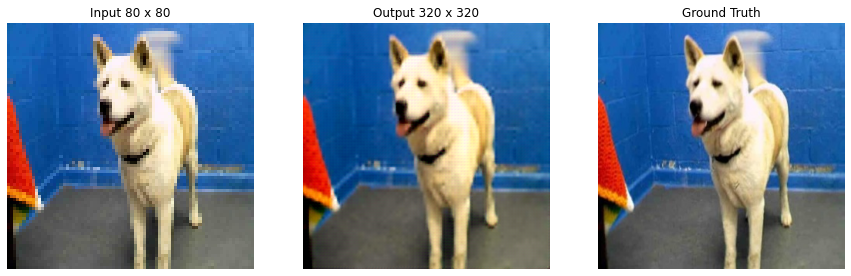

In [68]:
for epoch in range(NUM_EPOCH):
  data_loader.reset()
  for i in range(data_loader.max_):
    try:
      dataR, dataG, dataB, labelR, labelG, labelB = data_loader.__next__()
    except StopIteration:
      continue
    
    # Model output
    outR = ch_R(dataR)
    outG = ch_G(dataG)
    outB = ch_B(dataB)

    # Compute loss
    lossR = criterion(outR, labelR)
    lossG = criterion(outG, labelG)
    lossB = criterion(outB, labelB)

    # Compute gradients
    lossR.backward()
    lossG.backward()
    lossB.backward()
    
    # Update params
    optimizerR.step()
    optimizerG.step()
    optimizerB.step()
    
    # Make zero grad
    optimizerR.zero_grad()
    optimizerG.zero_grad()
    optimizerB.zero_grad()

    #print(f'Epoch : {epoch+1} -> R : {lossR:.4} G : {lossG:.4} B : {lossB:.4}')
    
    # Clear output
    display.clear_output(wait=True)

    # Plot figure
    fig = plt.figure(figsize=(15,10))
    
    # Detach each color channel and create RGB image matrix (Input)
    imR = dataR.detach().numpy()[0]
    imG = dataG.detach().numpy()[0]
    imB = dataB.detach().numpy()[0]
    img_input = np.zeros((data_loader.limsize[0], data_loader.limsize[1], 3))
    img_input[:, :, 0] = imR.reshape((data_loader.limsize[0], data_loader.limsize[1]))
    img_input[:, :, 1] = imG.reshape((data_loader.limsize[0], data_loader.limsize[1]))
    img_input[:, :, 2] = imB.reshape((data_loader.limsize[0], data_loader.limsize[1]))

    fig.add_subplot(1, 3, 1)
    plt.imshow((img_input * 255).astype(np.uint8))
    plt.axis('off')
    plt.title(f"Input {data_loader.limsize[0]} x {data_loader.limsize[1]}")

    # Detach each color channel and create RGB image matrix (Output)
    lbR = outR.detach().numpy()[0]
    lbG = outG.detach().numpy()[0]
    lbB = outB.detach().numpy()[0]
    img_out = np.zeros((320, 320, 3))
    img_out[:, :, 0] = lbR.reshape((320, 320))
    img_out[:, :, 1] = lbG.reshape((320, 320))
    img_out[:, :, 2] = lbB.reshape((320, 320))
    
    fig.add_subplot(1, 3, 2)
    plt.imshow(img_out)
    plt.axis('off')
    plt.title("Output 320 x 320")

    # Detach each color channel and create RGB image matrix (Ground Truth)
    gtR = labelR.detach().numpy()[0]
    gtG = labelG.detach().numpy()[0]
    gtB = labelB.detach().numpy()[0]
    gt_out = np.zeros((320, 320, 3))
    gt_out[:, :, 0] = gtR.reshape((320, 320))
    gt_out[:, :, 1] = gtG.reshape((320, 320))
    gt_out[:, :, 2] = gtB.reshape((320, 320))
    
    fig.add_subplot(1, 3, 3)
    plt.imshow((gt_out * 255).astype(np.uint8))
    plt.axis('off')
    plt.title("Ground Truth")
    plt.show()

## Test

In [48]:
!mkdir /content/test

In [55]:
!wget -P test/ https://i.pinimg.com/originals/53/5e/9a/535e9a9a53757b38523120feaa32faed.png

--2021-09-12 17:35:09--  https://i.pinimg.com/originals/53/5e/9a/535e9a9a53757b38523120feaa32faed.png
Resolving i.pinimg.com (i.pinimg.com)... 104.70.191.146, 2600:1408:8c00:788::1931, 2600:1408:8c00:781::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|104.70.191.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131191 (128K) [image/png]
Saving to: ‘test/535e9a9a53757b38523120feaa32faed.png’

535e9a9a53757b38523 100%[===================>] 128.12K  --.-KB/s    in 0.05s   

2021-09-12 17:35:09 (2.35 MB/s) - ‘test/535e9a9a53757b38523120feaa32faed.png’ saved [131191/131191]



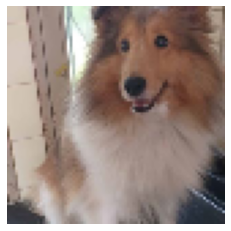

In [58]:
test_im = cv.imread("/content/test/535e9a9a53757b38523120feaa32faed.png", cv.IMREAD_ANYCOLOR)
test_gt = test_im.copy()
test_im = cv.resize(test_im, (80, 80))

vis = cv.cvtColor(test_im, cv.COLOR_BGR2RGB)
plt.imshow(vis)
plt.axis('off')
plt.show()

In [60]:
testR = ch_R(torch.Tensor(test_im[:,:,2].reshape((1, 1, 80, 80))))
testG = ch_G(torch.Tensor(test_im[:,:,1].reshape((1, 1, 80, 80))))
testB = ch_B(torch.Tensor(test_im[:,:,0].reshape((1, 1, 80, 80))))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


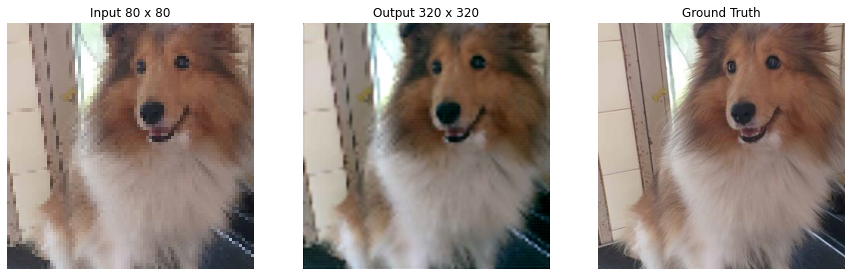

In [64]:
    # Plot figure
    fig1 = plt.figure(figsize=(15,10))

    fig1.add_subplot(1, 3, 1)
    plt.imshow(cv.cvtColor(test_im, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Input 80 x 80")

    R = testR.detach().numpy()
    G = testG.detach().numpy()
    B = testB.detach().numpy()
    RGB_out = np.zeros((320, 320, 3))
    RGB_out[:, :, 0] = R.reshape((320, 320))
    RGB_out[:, :, 1] = G.reshape((320, 320))
    RGB_out[:, :, 2] = B.reshape((320, 320))
    
    fig1.add_subplot(1, 3, 2)
    plt.imshow(RGB_out)
    plt.axis('off')
    plt.title("Output 320 x 320")
    
    fig1.add_subplot(1, 3, 3)
    plt.imshow(cv.cvtColor(test_gt, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Ground Truth")
    plt.show()

## Save Models

In [43]:
!mkdir /content/models

In [45]:
torch.save(ch_R.state_dict(), "/content/models/modelR")
torch.save(ch_G.state_dict(), "/content/models/modelG")
torch.save(ch_B.state_dict(), "/content/models/modelB")

In [47]:
!ls /content/models

modelB	modelG	modelR
